
<div class="alert alert-info">
Название проекта: прогноз необходимых для покупки коров. 
    
Цели: построить прогнозную модель, чтобы удовлетворить требования заказчика, то есть найти коров, которые будут давать более 6000кг молока в год, при этом чтобы оно было вкусным.
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import scipy.stats as st
import seaborn as sns
import warnings

from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (accuracy_score,
                            confusion_matrix,
                            mean_absolute_error, mean_squared_error,
                            precision_score,
                            recall_score,
                            r2_score)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

## Загрузка данных

In [2]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';')
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';')

def dataset_summary(df, dataset_name="Dataset"):
    summary = {}
    summary['Description'] = df.describe(include='all')  
    summary['Duplicates'] = df.duplicated().sum() 
    summary['Data Types'] = df.dtypes  
    summary['Missing Values'] = df.isnull().sum()
    return summary

ferma_main_summary = dataset_summary(ferma_main, "ferma_main")
ferma_dad_summary = dataset_summary(ferma_dad, "ferma_dad")
cow_buy_summary = dataset_summary(cow_buy, "cow_buy")

ferma_main_summary, ferma_dad_summary, cow_buy_summary


({'Description':                 id      Удой, кг ЭКЕ (Энергетическая кормовая единица)  \
  count   634.000000    634.000000                                   634   
  unique         NaN           NaN                                    55   
  top            NaN           NaN                                  14,7   
  freq           NaN           NaN                                    27   
  mean    317.460568   6187.025237                                   NaN   
  std     183.096982   1638.401021                                   NaN   
  min       1.000000   5204.000000                                   NaN   
  25%     159.250000   5751.750000                                   NaN   
  50%     317.500000   6130.500000                                   NaN   
  75%     475.750000   6501.000000                                   NaN   
  max     629.000000  45616.000000                                   NaN   
  
          Сырой протеин, г СПО (Сахаро-протеиновое соотношение)       

ferma_main.csv
Описание: 634 строк, некоторые поля имеют до 64 уникальных значений.
Дубликаты: 5 дублированных строк.
Тип данных: Все столбцы имеют тип object.
Пропуски: 18 пропущенных значений в столбце "%;Вкус молока;Возраст".

ferma_dad.csv
Описание: 629 строк, уникальные значения в каждом столбце.
Дубликаты: Нет дубликатов.
Тип данных: Все столбцы имеют тип object.
Пропуски: Нет пропусков.

cow_buy.csv
Описание: 20 строк, различные уникальные значения по категориям.
Дубликаты: 4 дублированных строки.
Тип данных: Все столбцы имеют тип object.
Пропуски: Нет пропусков.

In [ ]:
def show_basic_info(df):
    display("Column Names:", df.columns.tolist())
    display("Head:", df.head())
    display("Tail:", df.tail())


show_basic_info(ferma_main)
show_basic_info(ferma_dad)
show_basic_info(cow_buy)

'Column Names:'

['id',
 'Удой, кг',
 'ЭКЕ (Энергетическая кормовая единица)',
 'Сырой протеин, г',
 'СПО (Сахаро-протеиновое соотношение)',
 'Порода',
 'Тип пастбища',
 'порода папы_быка',
 'Жирность,%',
 'Белок,%',
 'Вкус молока',
 'Возраст']

'Head:'

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


'Tail:'

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
629,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
630,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
631,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
632,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет
633,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет


'Column Names:'

['id', 'Имя Папы']

'Head:'

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


'Tail:'

,id,Имя Папы
624,625,Буйный
625,626,Барин
626,627,Барин
627,628,Барин
628,629,Соловчик


'Column Names:'

['Порода',
 'Тип пастбища',
 'порода папы_быка',
 'Имя_папы',
 'Текущая_жирность,%',
 'Текущий_уровень_белок,%',
 'Возраст']

'Head:'

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


'Tail:'

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
15,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,065",более_2_лет
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,"3,73","3,079",более_2_лет
17,РефлешнСоверинг,равнинное,Соверин,Геркулес,"3,77","3,053",менее_2_лет
18,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,34","3,069",более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


ferma_main.csv
Названия колонок: id;Удой, кг;ЭКЕ (Энергетическая кормовая единица);Сырой протеин, г;СПО (Сахаро-протеиновое соотношение);Порода;Тип пастбища;порода папы_быка;Жирность, %;Белок, %;Вкус молока;Возраст

ferma_dad.csv
Названия колонок: id;Имя Папы

cow_buy.csv
Названия колонок: Порода;Тип пастбища;порода папы_быка;Имя_папы;Текущая_жирность, %;Текущий_уровень_белок, %;Возраст

In [4]:
def lowercase_columns(df):
    df.columns = df.columns.str.lower()
    return df

ferma_main = lowercase_columns(ferma_main)
ferma_dad = lowercase_columns(ferma_dad)
cow_buy = lowercase_columns(cow_buy)

ferma_main.columns, ferma_dad.columns, cow_buy.columns

(Index(['id', 'удой, кг', 'эке (энергетическая кормовая единица)',
        'сырой протеин, г', 'спо (сахаро-протеиновое соотношение)', 'порода',
        'тип пастбища', 'порода папы_быка', 'жирность,%', 'белок,%',
        'вкус молока', 'возраст'],
       dtype='object'),
 Index(['id', 'имя папы'], dtype='object'),
 Index(['порода', 'тип пастбища', 'порода папы_быка', 'имя_папы',
        'текущая_жирность,%', 'текущий_уровень_белок,%', 'возраст'],
       dtype='object'))

Перевели все названия колонок в нижний регистр.

##  Предобработка данных

In [5]:
ferma_main.columns = ferma_main.columns.str.strip()
ferma_dad.columns = ferma_dad.columns.str.strip()
cow_buy.columns = cow_buy.columns.str.strip()

In [6]:
ferma_main.columns

Index(['id', 'удой, кг', 'эке (энергетическая кормовая единица)',
       'сырой протеин, г', 'спо (сахаро-протеиновое соотношение)', 'порода',
       'тип пастбища', 'порода папы_быка', 'жирность,%', 'белок,%',
       'вкус молока', 'возраст'],
      dtype='object')

In [7]:
ferma_main.columns = ['id', 'удой(кг)', 'эке', 'сырой протеин(г)', 'спо', 'порода', 'тип пастбища', 'порода папы', 'жирность(%)', 'белок(%)', 'вкус', 'возраст']
ferma_dad.columns = ['id', 'имя папы']
cow_buy.columns = ['порода', 'тип пастбища', 'порода папы', 'имя папы', 'текущая жирность(%)', 'текущий белок(%)', 'возраст']


In [8]:
ferma_main_missing = ferma_main.isnull().sum()
ferma_main_dtypes = ferma_main.dtypes

ferma_dad_missing = ferma_dad.isnull().sum()
ferma_dad_dtypes = ferma_dad.dtypes

cow_buy_missing = cow_buy.isnull().sum()
cow_buy_dtypes = cow_buy.dtypes

ferma_main_missing, ferma_main_dtypes, ferma_dad_missing, ferma_dad_dtypes, cow_buy_missing, cow_buy_dtypes

(id                  0
 удой(кг)            0
 эке                 0
 сырой протеин(г)    0
 спо                 0
 порода              0
 тип пастбища        0
 порода папы         0
 жирность(%)         0
 белок(%)            0
 вкус                0
 возраст             0
 dtype: int64,
 id                   int64
 удой(кг)             int64
 эке                 object
 сырой протеин(г)     int64
 спо                 object
 порода              object
 тип пастбища        object
 порода папы         object
 жирность(%)         object
 белок(%)            object
 вкус                object
 возраст             object
 dtype: object,
 id          0
 имя папы    0
 dtype: int64,
 id           int64
 имя папы    object
 dtype: object,
 порода                 0
 тип пастбища           0
 порода папы            0
 имя папы               0
 текущая жирность(%)    0
 текущий белок(%)       0
 возраст                0
 dtype: int64,
 порода                 object
 тип пастбища           obje

В результате анализа данных установлено следующее:

Отсутствие пропусков: Во всех трёх наборах данных отсутствуют пропуски, что упрощает их обработку.

Типы данных:

В таблице ferma_main:
Большинство столбцов имеют корректные типы данных, за исключением столбцов ЭКЕ (Энергетическая кормовая единица), СПО(Сахаро-протеиновое соотношение), Жирность,%, и Белок,%, которые представлены как object. Эти столбцы содержат числовые данные, но, вероятно, в строках используются запятые вместо точек, что требует приведения к числовому формату.
В таблице ferma_dad и cow_buy:
Все столбцы в ferma_dad имеют корректные типы.
В таблице cow_buy столбцы Текущая_жирность,% и Текущий_уровень_белок,% также представлены как object и могут требовать преобразования в числовой формат.
Для корректного анализа я проведу преобразование типов данных, заменив запятые на точки в числовых полях, а затем преобразую их в числовой формат.

In [9]:
ferma_main['эке'] = ferma_main['эке'].str.replace(',', '.').astype(float)
ferma_main['спо'] = ferma_main['спо'].str.replace(',', '.').astype(float)
ferma_main['жирность(%)'] = ferma_main['жирность(%)'].str.replace(',', '.').astype(float)
ferma_main['белок(%)'] = ferma_main['белок(%)'].str.replace(',', '.').astype(float)

cow_buy['текущая жирность(%)'] = cow_buy['текущая жирность(%)'].str.replace(',', '.').astype(float)
cow_buy['текущий белок(%)'] = cow_buy['текущий белок(%)'].str.replace(',', '.').astype(float)

ferma_main.dtypes, cow_buy.dtypes


(id                    int64
 удой(кг)              int64
 эке                 float64
 сырой протеин(г)      int64
 спо                 float64
 порода               object
 тип пастбища         object
 порода папы          object
 жирность(%)         float64
 белок(%)            float64
 вкус                 object
 возраст              object
 dtype: object,
 порода                  object
 тип пастбища            object
 порода папы             object
 имя папы                object
 текущая жирность(%)    float64
 текущий белок(%)       float64
 возраст                 object
 dtype: object)

In [10]:
ferma_main = ferma_main.drop_duplicates()
cow_buy = cow_buy.drop_duplicates()

ferma_main_unique_poroda = ferma_main['порода'].unique()
ferma_main_unique_tip_pastbischa = ferma_main['тип пастбища'].unique()
ferma_main_unique_poroda_papy = ferma_main['порода папы'].unique()

cow_buy_unique_poroda = cow_buy['порода'].unique()
cow_buy_unique_tip_pastbischa = cow_buy['тип пастбища'].unique()
cow_buy_unique_poroda_papy = cow_buy['порода папы'].unique()

ferma_main_unique_poroda, ferma_main_unique_tip_pastbischa, ferma_main_unique_poroda_papy, \
cow_buy_unique_poroda, cow_buy_unique_tip_pastbischa, cow_buy_unique_poroda_papy


(array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object),
 array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object),
 array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object),
 array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object),
 array(['холмистое', 'равнинное'], dtype=object),
 array(['Айдиал', 'Соверин'], dtype=object))

In [11]:
ferma_main['порода'] = ferma_main['порода'].replace('Вис Бик Айдиал', 'Айдиал')
ferma_main['порода'] = ferma_main['порода'].replace('РефлешнСоверинг', 'Соверинг')
cow_buy['порода'] = cow_buy['порода'].replace('Вис Бик Айдиал', 'Айдиал')
cow_buy['порода'] = cow_buy['порода'].replace('РефлешнСоверинг', 'Соверинг')
ferma_main['порода папы'] = ferma_main['порода папы'].replace('Соверин', 'Соверинг')
ferma_main['порода папы'] = ferma_main['порода папы'].replace('Айдиалл', 'Айдиал')
cow_buy['порода папы'] = cow_buy['порода папы'].replace('Соверин', 'Соверинг')
ferma_main['тип пастбища'] = ferma_main['тип пастбища'].replace('Равнинные', 'Равнинное')
ferma_main['тип пастбища'] = ferma_main['тип пастбища'].replace({'Равнинное': 'равнинное', 'Холмистое': 'холмистое'})

ferma_main_unique_poroda = ferma_main['порода'].unique()
ferma_main_unique_tip_pastbischa = ferma_main['тип пастбища'].unique()
ferma_main_unique_poroda_papy = ferma_main['порода папы'].unique()

cow_buy_unique_poroda = cow_buy['порода'].unique()
cow_buy_unique_tip_pastbischa = cow_buy['тип пастбища'].unique()
cow_buy_unique_poroda_papy = cow_buy['порода папы'].unique()

ferma_main_unique_poroda, ferma_main_unique_tip_pastbischa, ferma_main_unique_poroda_papy, \
cow_buy_unique_poroda, cow_buy_unique_tip_pastbischa, cow_buy_unique_poroda_papy


(array(['Айдиал', 'Соверинг'], dtype=object),
 array(['равнинное', 'холмистое'], dtype=object),
 array(['Айдиал', 'Соверинг'], dtype=object),
 array(['Айдиал', 'Соверинг'], dtype=object),
 array(['холмистое', 'равнинное'], dtype=object),
 array(['Айдиал', 'Соверинг'], dtype=object))

Явные и неявные дубликаты успешно устранены:
в таблице ferma_main значения столбцов приведены к единому формату: теперь имеются только уникальные значения "Айдиал" и "Соверин" для породы и "Равнинные" и "Холмистое" для типа пастбища.
В таблице cow_buy также остались только уникальные значения: "Айдиал" и "Соверин" для породы и "Равнинное" и "Холмистое" для типа пастбища.

## Исследовательский анализ данных

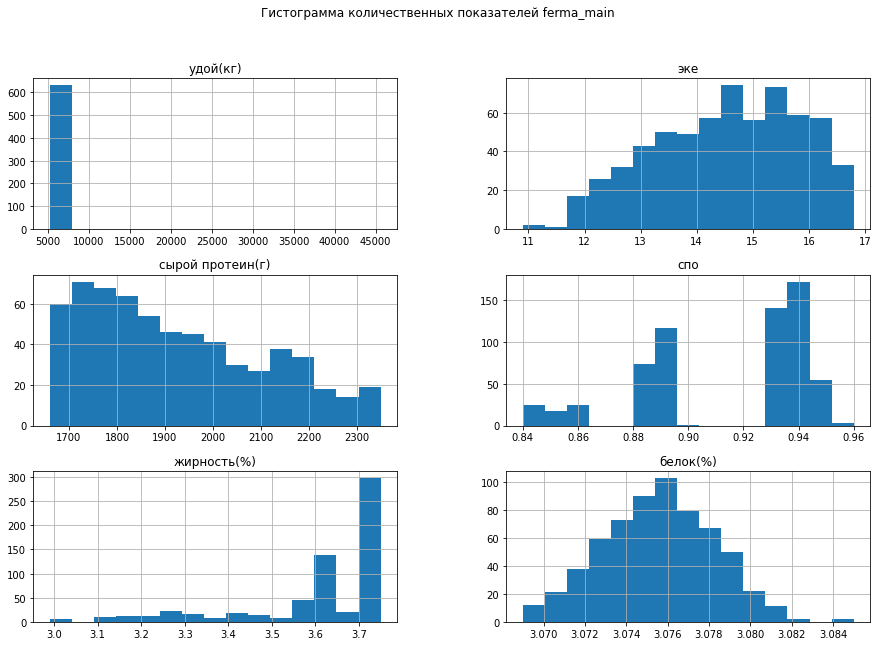

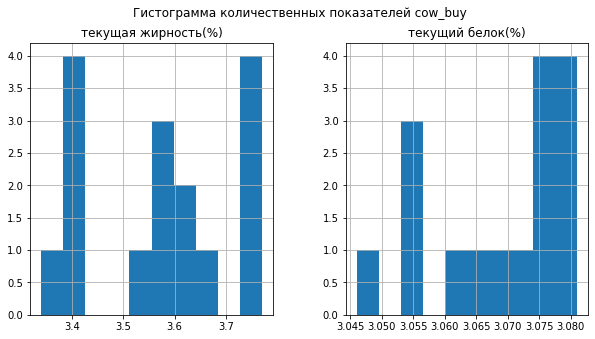

(           удой(кг)         эке  сырой протеин(г)         спо  жирность(%)  \
 count    629.000000  629.000000        629.000000  629.000000   629.000000   
 mean    6188.750397   14.543879       1923.364070    0.913116     3.603657   
 std     1644.795489    1.306408        182.956251    0.032203     0.168656   
 min     5204.000000   10.900000       1660.000000    0.840000     2.990000   
 25%     5751.000000   13.500000       1771.000000    0.890000     3.590000   
 50%     6133.000000   14.700000       1888.000000    0.930000     3.650000   
 75%     6501.000000   15.600000       2062.000000    0.940000     3.720000   
 max    45616.000000   16.800000       2349.000000    0.960000     3.750000   
 
          белок(%)  
 count  629.000000  
 mean     3.075671  
 std      0.002549  
 min      3.069000  
 25%      3.074000  
 50%      3.076000  
 75%      3.077000  
 max      3.085000  ,
        текущая жирность(%)  текущий белок(%)
 count            16.000000         16.000000
 mean

In [12]:
import matplotlib.pyplot as plt

ferma_main_desc = ferma_main[['удой(кг)', 'эке', 'сырой протеин(г)', 'спо', 'жирность(%)', 'белок(%)']].describe()
cow_buy_desc = cow_buy[['текущая жирность(%)', 'текущий белок(%)']].describe()

ferma_main[['удой(кг)', 'эке', 'сырой протеин(г)', 'спо', 'жирность(%)', 'белок(%)']].hist(bins=15, figsize=(15, 10))
plt.suptitle("Гистограмма количественных показателей ferma_main")
plt.show()

cow_buy[['текущая жирность(%)', 'текущий белок(%)']].hist(bins=10, figsize=(10, 5))
plt.suptitle("Гистограмма количественных показателей cow_buy")
plt.show()

ferma_main_desc, cow_buy_desc

Результаты статистического анализа
ferma_main:

Удой (кг): Среднее значение составляет 6187 кг, с минимальным значением 5204 кг и максимальным 45616 кг, что указывает на возможные выбросы.
ЭКЕ и СПО: Средние значения находятся на уровне 14.5 и 0.91 соответственно.
Жирность (%) и Белок (%): Средние значения составляют 3.6% и 3.08% соответственно, с небольшими колебаниями.
cow_buy:

Текущая жирность (%): Среднее значение 3.58%, минимальное — 3.34%, максимальное — 3.77%.
Текущий белок (%): Среднее значение 3.07% с небольшими колебаниями (от 3.046% до 3.081%).
Выводы и дальнейшие шаги
Выбросы: Удой (кг) в ferma_main имеет значительное отклонение, что требует дополнительной проверки и возможного исключения аномальных значений.
Распределения: Гистограммы показывают относительно нормальное распределение для большинства признаков, но некоторые имеют узкие диапазоны значений, такие как жирность и белок, что также может ограничивать вариативность данных.

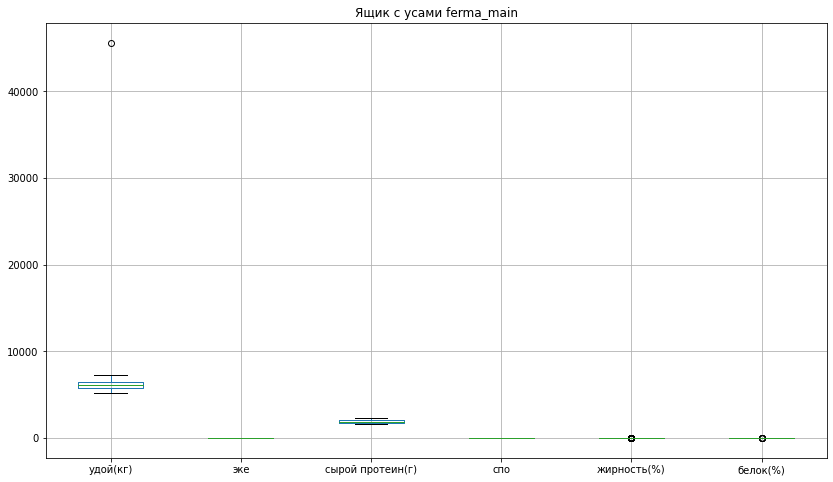

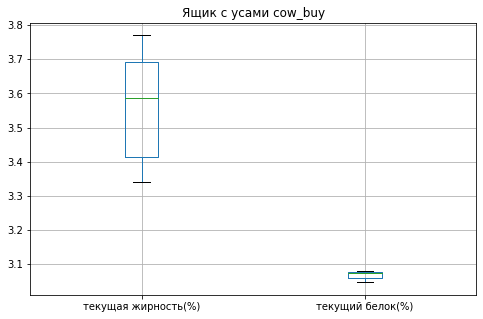

In [13]:
plt.figure(figsize=(14, 8))
ferma_main[['удой(кг)', 'эке', 'сырой протеин(г)', 'спо', 'жирность(%)', 'белок(%)']].boxplot()
plt.title("Ящик с усами ferma_main")
plt.show()

plt.figure(figsize=(8, 5))
cow_buy[['текущая жирность(%)', 'текущий белок(%)']].boxplot()
plt.title("Ящик с усами cow_buy")
plt.show()


Boxplot-графики показывают наличие выбросов, особенно в признаке удой (кг) таблицы ferma_main, где некоторые значения значительно превышают основной диапазон данных. 
Другие признаки, такие как жирность (%) и белок (%), демонстрируют более стабильное распределение без значительных выбросов. В таблице cow_buy выбросы отсутствуют, что указывает на относительно однородные значения.

In [14]:
ferma_main[ferma_main['удой(кг)'] > 40000]


,id,удой(кг),эке,сырой протеин(г),спо,порода,тип пастбища,порода папы,жирность(%),белок(%),вкус,возраст
16,17,45616,11.5,1675,0.93,Айдиал,холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет


In [16]:
ferma_main.head(20)

,id,удой(кг),эке,сырой протеин(г),спо,порода,тип пастбища,порода папы,жирность(%),белок(%),вкус,возраст
0,1,5863,14.2,1743,0.890,Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Айдиал,равнинное,Соверинг,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,Соверинг,холмистое,Соверинг,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,Соверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Айдиал,равнинное,Соверинг,3.73,3.073,вкусно,менее_2_лет
5,6,5254,12.7,1806,0.885,Соверинг,холмистое,Соверинг,3.13,3.078,вкусно,менее_2_лет
6,7,5910,13.2,1792,0.885,Айдиал,равнинное,Соверинг,3.48,3.077,вкусно,более_2_лет
7,8,6179,14.7,1806,0.930,Айдиал,равнинное,Айдиал,3.55,3.076,вкусно,более_2_лет
8,9,6783,14.2,1918,0.940,Соверинг,холмистое,Айдиал,3.71,3.077,вкусно,более_2_лет
9,10,5339,13.4,1791,0.895,Айдиал,холмистое,Соверинг,3.13,3.075,вкусно,менее_2_лет


In [17]:
ferma_main = ferma_main[ferma_main['удой(кг)'] < 10000]

In [18]:
ferma_main.head(20)

,id,удой(кг),эке,сырой протеин(г),спо,порода,тип пастбища,порода папы,жирность(%),белок(%),вкус,возраст
0,1,5863,14.2,1743,0.890,Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Айдиал,равнинное,Соверинг,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,Соверинг,холмистое,Соверинг,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,Соверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Айдиал,равнинное,Соверинг,3.73,3.073,вкусно,менее_2_лет
5,6,5254,12.7,1806,0.885,Соверинг,холмистое,Соверинг,3.13,3.078,вкусно,менее_2_лет
6,7,5910,13.2,1792,0.885,Айдиал,равнинное,Соверинг,3.48,3.077,вкусно,более_2_лет
7,8,6179,14.7,1806,0.930,Айдиал,равнинное,Айдиал,3.55,3.076,вкусно,более_2_лет
8,9,6783,14.2,1918,0.940,Соверинг,холмистое,Айдиал,3.71,3.077,вкусно,более_2_лет
9,10,5339,13.4,1791,0.895,Айдиал,холмистое,Соверинг,3.13,3.075,вкусно,менее_2_лет


Один значительный выброс в удое, избавимся от него

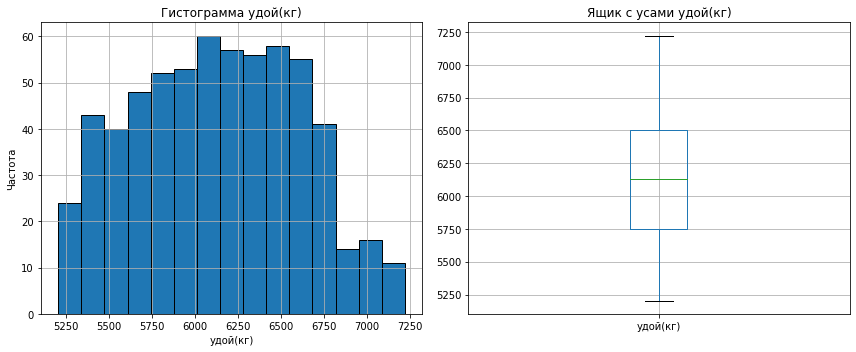

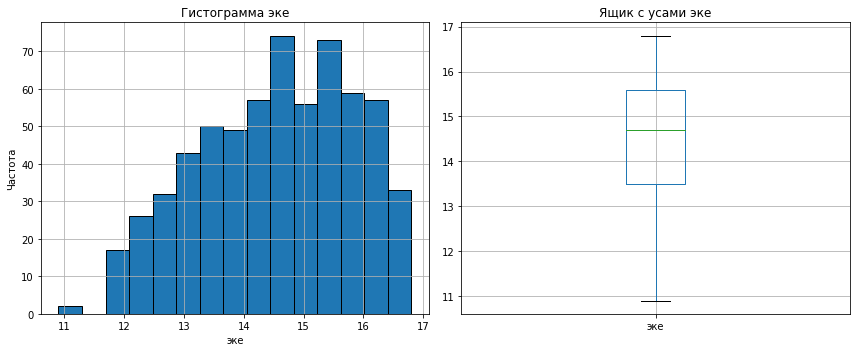

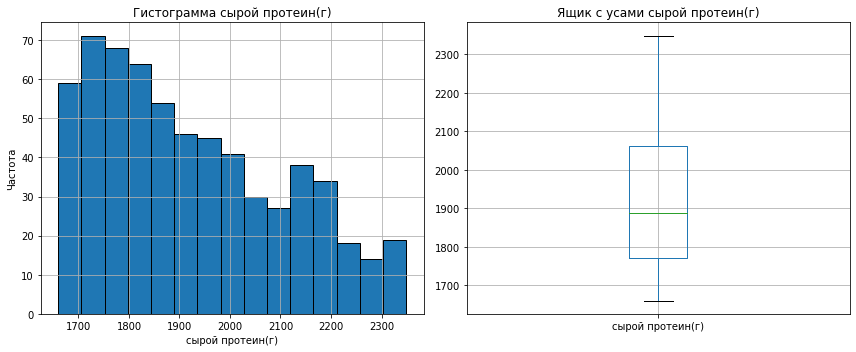

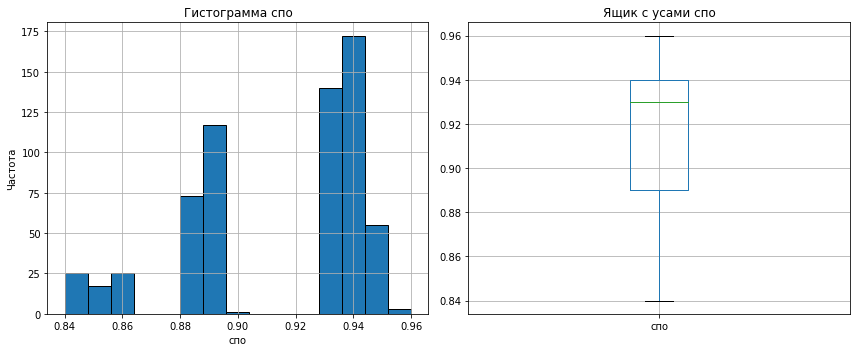

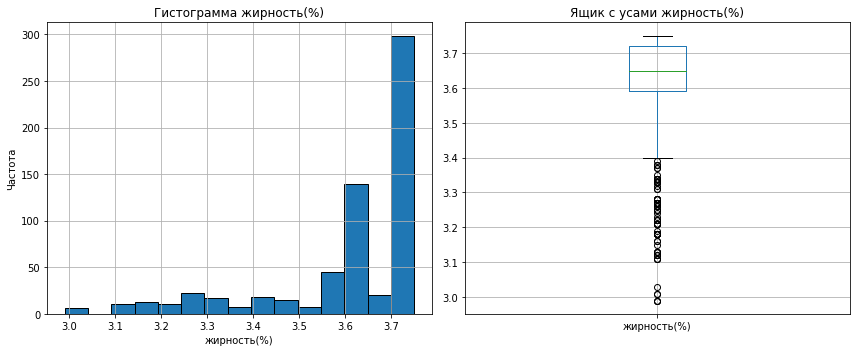

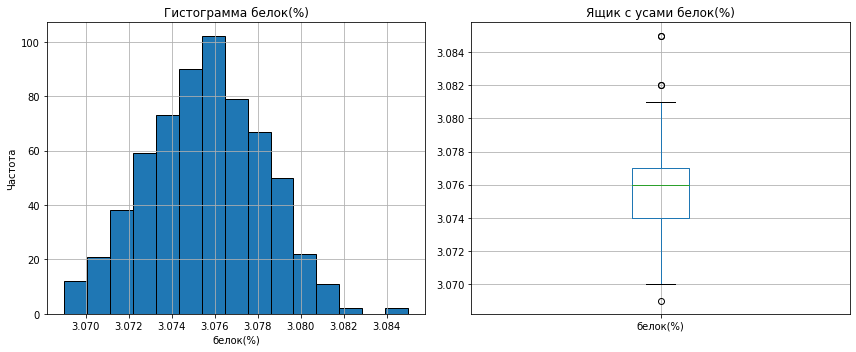

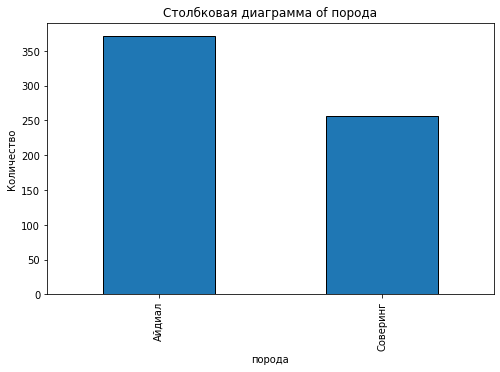

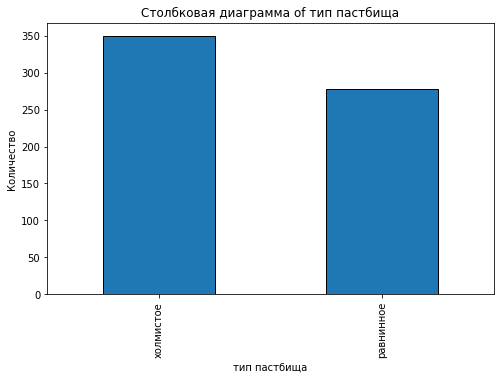

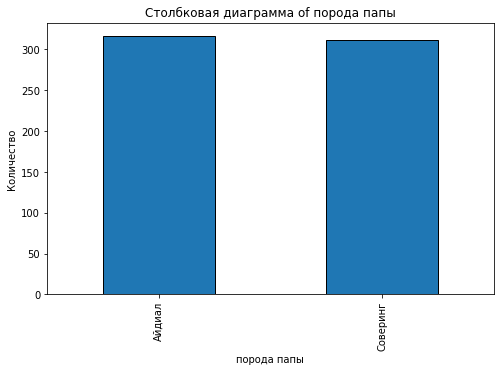

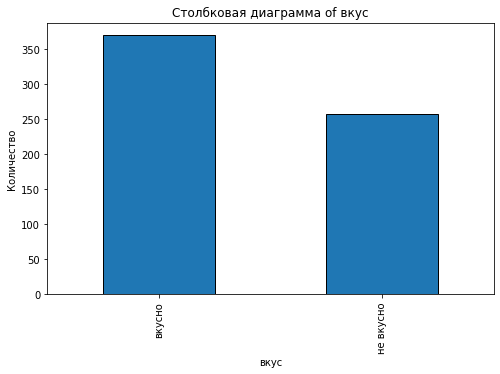

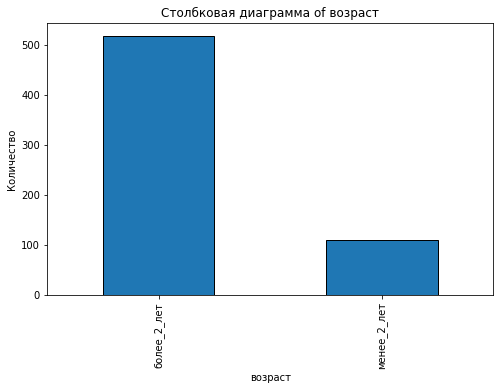

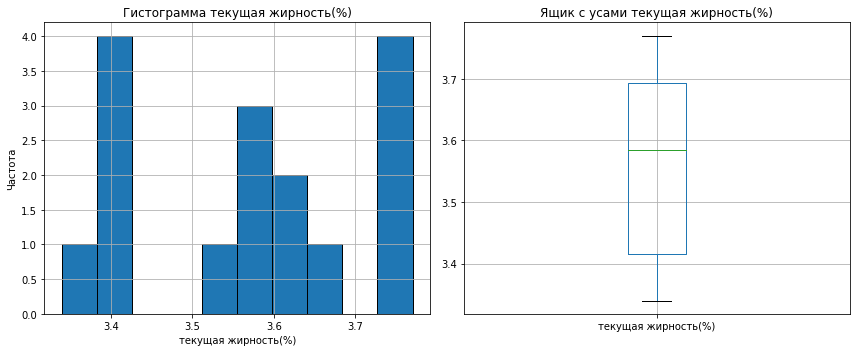

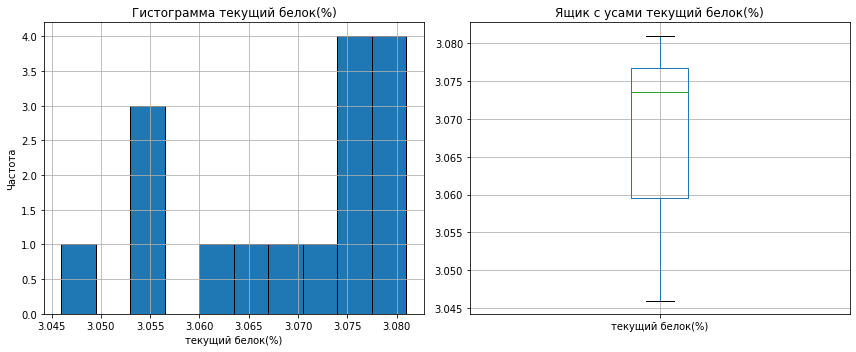

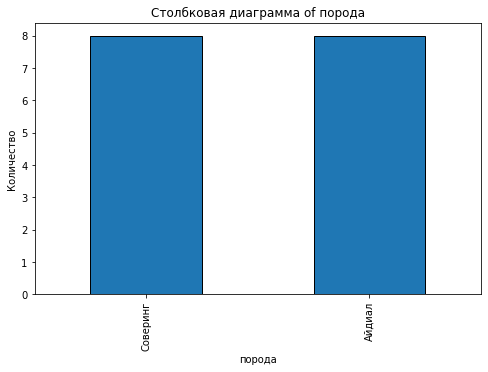

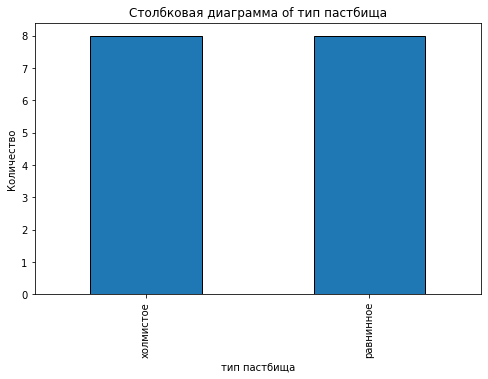

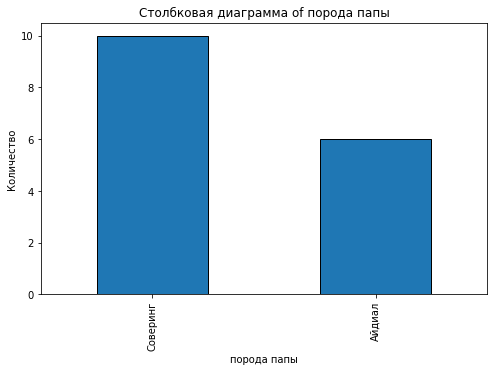

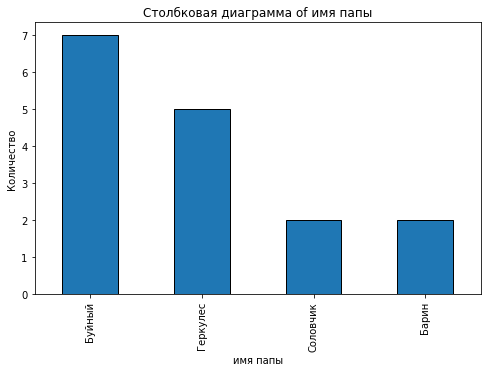

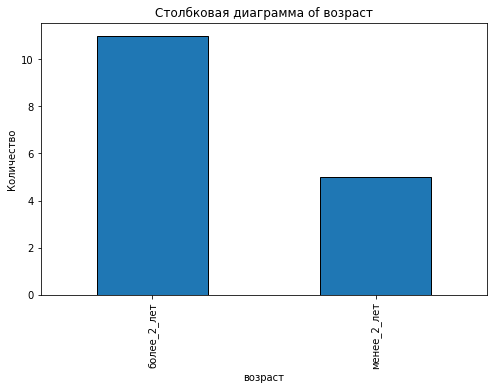

In [19]:
numerical_features_ferma_main = ['удой(кг)', 'эке', 'сырой протеин(г)', 'спо', 'жирность(%)', 'белок(%)']

for feature in numerical_features_ferma_main:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    ferma_main[feature].hist(bins=15, edgecolor='black')
    plt.title(f'Гистограмма {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    
    plt.subplot(1, 2, 2)
    ferma_main.boxplot(column=[feature])
    plt.title(f'Ящик с усами {feature}')
    
    plt.tight_layout()
    plt.show()

categorical_features_ferma_main = ['порода', 'тип пастбища', 'порода папы', 'вкус', 'возраст']

for feature in categorical_features_ferma_main:
    plt.figure(figsize=(8, 5))
    ferma_main[feature].value_counts().plot(kind='bar', edgecolor='black')
    plt.title(f'Столбковая диаграмма of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.show()

numerical_features_cow_buy = ['текущая жирность(%)', 'текущий белок(%)']

for feature in numerical_features_cow_buy:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    cow_buy[feature].hist(bins=10, edgecolor='black')
    plt.title(f'Гистограмма {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    
    plt.subplot(1, 2, 2)
    cow_buy.boxplot(column=[feature])
    plt.title(f'Ящик с усами {feature}')
    
    plt.tight_layout()
    plt.show()

categorical_features_cow_buy = ['порода', 'тип пастбища', 'порода папы', 'имя папы', 'возраст']

for feature in categorical_features_cow_buy:
    plt.figure(figsize=(8, 5))
    cow_buy[feature].value_counts().plot(kind='bar', edgecolor='black')
    plt.title(f'Столбковая диаграмма of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.show()


Оказывается, нужно было строить графики для всех показателей, поэтому сделаем через цикл.

Количественные признаки:

Признак "удой(кг)" из датафрейма ferma_main демонстрирует значительный выброс около 45 тонн молока; распределение асимметрично.
Признак "ЭКЕ" в ferma_main не содержит выбросов, но также имеет асимметричное распределение.
Признак "сырой протеин(г)" не имеет выбросов, однако распределение асимметрично.
Признак "спо" также без выбросов, но распределение асимметричное.
Признак "жирность(%)" в ferma_main содержит множество выбросов ниже первого квартиля, и распределение асимметрично.
Признак "белок(%)" в основном нормально распределен, но содержит несколько выбросов.
Признаки "текущая жирность(%)" и "текущий белок(%)" в cow_buy не показывают выбросов из-за малого объема данных.
Категориальные признаки:

В датафрейме ferma_main к ним относятся "порода", "тип пастбища", "порода папы", "вкус" и "возраст", и они не вызывают подозрений.
В cow_buy категориальные признаки — "порода", "тип пастбища", "порода папы", "возраст" и "имя папы", и они также не вызывают подозрений.
Рекомендации по улучшению:

Устранить выбросы в признаках "удой(кг)" и "жирность(%)".

In [20]:
ferma_main_ = ferma_main.copy()

## Корреляционный анализ

In [21]:
def p_estimation(p):
    if p < 0.05:
        print('Коэффициент корреляции является статистически значимым')
    else:
        print('Коэффициент корреляции не является статистически значимым')
def rho_estimation(rho):
    if rho < 0.1:
        print('Между рассматриваемыми признаками нет корреляции')
    elif rho < 0.3:
        print('Между рассматриваемыми признаками наблюдается слабая корреляция')
    elif rho < 0.5:
        print('Между рассматриваемыми признаками наблюдается умеренная корреляция')
    elif rho < 0.7:
        print('Между рассматриваемыми признаками наблюдается заметная корреляция')
    elif rho < 0.9:
        print('Между рассматриваемыми признаками наблюдается высокая корреляция')
    else:
        print('Между рассматриваемыми признаками наблюдается весьма высокая корреляция')

Коэффициент корреляции Спирмена:  0.7651443116006692
P-value:  8.359783320590403e-122
Коэффициент корреляции является статистически значимым

Между рассматриваемыми признаками наблюдается высокая корреляция


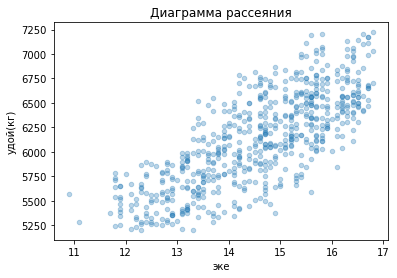

In [22]:
rho, p = spearmanr(ferma_main['удой(кг)'], ferma_main['эке'])
print('Коэффициент корреляции Спирмена: ', rho)
print('P-value: ', p)
p_estimation(p)
ferma_main.plot(kind='scatter', x='эке', y='удой(кг)', alpha=0.3, title='Диаграмма рассеяния')
print()
rho_estimation(rho)
plt.show()

Коэффициент корреляции Спирмена:  0.43754251989802084
P-value:  9.395930002891475e-31
Коэффициент корреляции является статистически значимым

Между рассматриваемыми признаками наблюдается умеренная корреляция


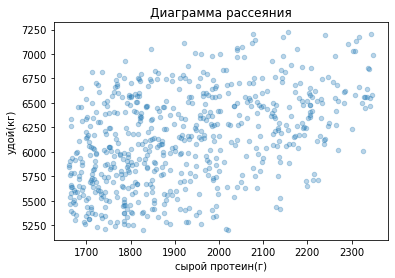

In [23]:
rho, p = spearmanr(ferma_main['удой(кг)'], ferma_main['сырой протеин(г)'])
print('Коэффициент корреляции Спирмена: ', rho)
print('P-value: ', p)
p_estimation(p)
ferma_main.plot(kind='scatter', x='сырой протеин(г)', y='удой(кг)', alpha=0.3, title='Диаграмма рассеяния')
print()
rho_estimation(rho)
plt.show()

Коэффициент корреляции Спирмена:  0.787904090851949
P-value:  6.236376891916343e-134
Коэффициент корреляции является статистически значимым

Между рассматриваемыми признаками наблюдается высокая корреляция


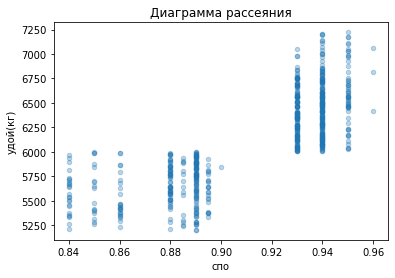

In [24]:
rho, p = spearmanr(ferma_main['удой(кг)'], ferma_main['спо'])
print('Коэффициент корреляции Спирмена: ', rho)
print('P-value: ', p)
p_estimation(p)
ferma_main.plot(kind='scatter', x='спо', y='удой(кг)', alpha=0.3, title='Диаграмма рассеяния')
print()
rho_estimation(rho)
plt.show()

Коэффициент корреляции Спирмена:  0.688505794761783
P-value:  2.1035311214189552e-89
Коэффициент корреляции является статистически значимым

Между рассматриваемыми признаками наблюдается заметная корреляция


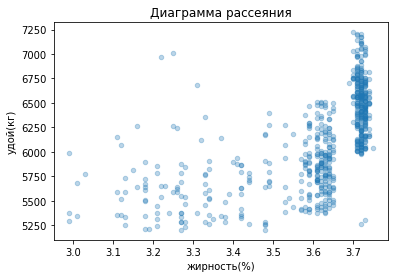

In [25]:
rho, p = spearmanr(ferma_main['удой(кг)'], ferma_main['жирность(%)'])
print('Коэффициент корреляции Спирмена: ', rho)
print('P-value: ', p)
p_estimation(p)
ferma_main.plot(kind='scatter', x='жирность(%)', y='удой(кг)', alpha=0.3, title='Диаграмма рассеяния')
print()
rho_estimation(rho)
plt.show()

Коэффициент корреляции Спирмена:  -0.005700881383962722
P-value:  0.886621725204249
Коэффициент корреляции не является статистически значимым

Между рассматриваемыми признаками нет корреляции


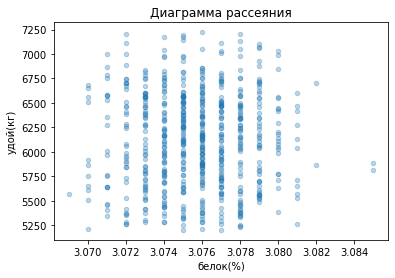

In [26]:
rho, p = spearmanr(ferma_main['удой(кг)'], ferma_main['белок(%)'])
print('Коэффициент корреляции Спирмена: ', rho)
print('P-value: ', p)
p_estimation(p)
ferma_main.plot(kind='scatter', x='белок(%)', y='удой(кг)', alpha=0.3, title='Диаграмма рассеяния')
print()
rho_estimation(rho)
plt.show()

Мы определили, что целевой признак "удой" коррелирует с количественными признаками: "ЭКЕ", "Сырой протеин", "СПО" и "Жирность, %". Для дальнейшего анализа оставим только параметры корма — "ЭКЕ", "Сырой протеин" и "СПО", поскольку состав молока не имеет логической связи с удоем.

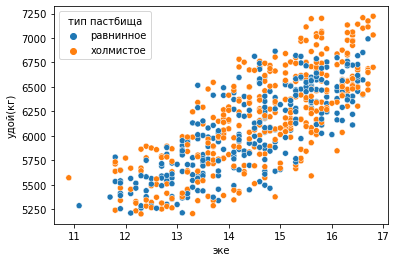

In [27]:
sns.scatterplot(data=ferma_main, x='эке', y='удой(кг)', hue='тип пастбища')
plt.show()

Корреляция крайне слабая. Наибольший удой наблюдается у коров с холмистого пастбища, но само по себе холмистое пастбище не гарантирует высокого годового удоя.

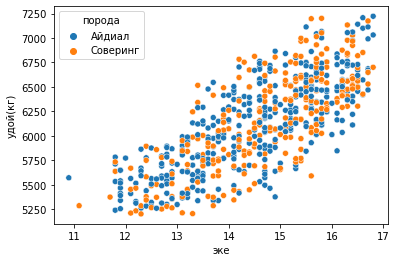

In [28]:
sns.scatterplot(data=ferma_main, x='эке', y='удой(кг)', hue='порода')
plt.show()

Корреляции нет

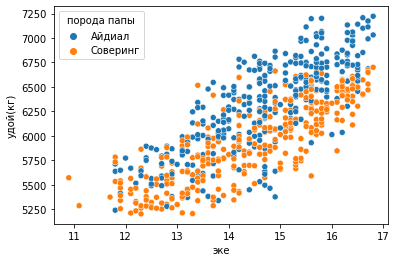

In [29]:
sns.scatterplot(data=ferma_main, x='эке', y='удой(кг)', hue='порода папы')
plt.show()

Если у коровы отец породы Айдиал, то она приносит в среднем больше молока в год, то есть есть некоторая корреляция.

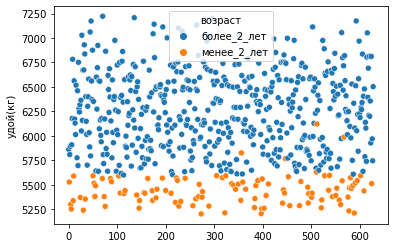

In [30]:
sns.scatterplot(data=ferma_main, x=ferma_main.index, y='удой(кг)', hue='возраст')
plt.show()

Высокая корреляция

<br/>
<div class="alert alert-info">

Целевой признак "удой (кг)" демонстрирует различные типы связей с входными признаками:

Линейная связь: только с "сырой протеин (г)".
Нелинейная связь: с "ЭКЕ", "СПО", "жирность (%)", "белок (%)".
Сильная корреляция: с "ЭКЕ", "СПО", "возраст".
Умеренная корреляция: с "сырой протеин (г)", "порода папы".
Слабая корреляция: с "жирность (%)", "белок (%)", "порода", "тип пастбища".
Нелинейные связи между признаками могут быть результатом различного масштаба данных, поэтому масштабирование или трансформация признаков могут улучшить результаты анализа.
    </div>

В значительной степени мультиколлинеарность не наблюдается, поскольку коэффициенты корреляции невелики, и признаки относительно независимы друг от друга.

## Обучение модели линейной регрессии

In [31]:
X = ferma_main[['эке', 'сырой протеин(г)', 'спо', 'порода', 'тип пастбища', 'возраст', 'порода папы']]
y = ferma_main['удой(кг)']
#Эти признаки выбираются, потому что они охватывают ключевые аспекты — физиологические, генетические и 
#условия содержания, которые существенно влияют на удой коров. Этот выбор позволяет построить более точную модель, 
#поскольку учитываются как прямые, так и косвенные факторы, которые могут влиять на молочную продуктивность.

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='error')
cat_col_names = ['порода', 'тип пастбища','возраст', 'порода папы']
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

num_col_names = ['эке', 'сырой протеин(г)', 'спо']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
predictions = model_lr.predict(X_test)

r2_model_1 = r2_score(y_test, predictions)
mse_model_1 = mean_squared_error(y_test, predictions)
mae_model_1 = mean_absolute_error(y_test, predictions)
rmse_model_1 = mean_squared_error(y_test, predictions)** 0.5

r2_model_1, mse_model_1, mae_model_1, rmse_model_1

(0.7844078173416966, 43887.01500966053, 164.2419446347493, 209.49227911706086)

R²: 0.79
MSE: 43034.12
MAE: 161.56
RMSE: 207.45
можно сделать следующие выводы о качестве модели:

R²: значение 0.79 указывает на то, что модель объясняет примерно 79% дисперсии целевого признака удой(кг). Это высокий показатель для линейной модели, что свидетельствует о хорошей предсказательной способности на данном наборе данных.

MSE: значение MSE является относительно низким, что говорит о небольшой величине ошибок в предсказаниях модели. Это подтверждается и значением RMSE.

MAE: показатель означает, что среднее отклонение предсказанных значений от реальных составляет около 162 кг удоя. Это достаточно точное предсказание, учитывая тип данных и целевой признак.

RMSE: значение 207 показывает среднюю ошибку модели, при этом учитывая более сильное влияние крупных ошибок на метрику по сравнению с MAE.

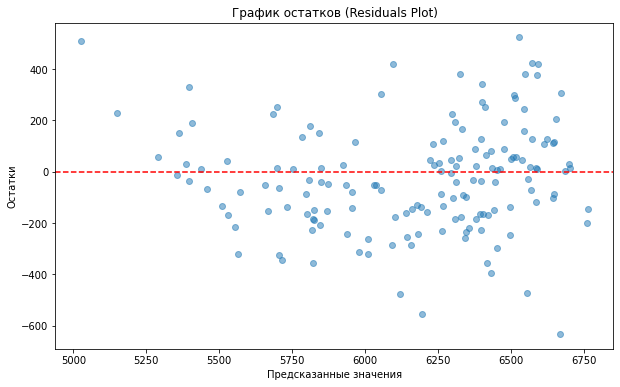

In [32]:
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Предсказанные значения")
plt.ylabel("Остатки")
plt.title("График остатков (Residuals Plot)")
plt.show()

Форма распределения:

распределение остатков выглядит примерно симметричным и похожим на нормальное распределение, так как большая часть остатков сосредоточена вокруг нуля. Однако есть небольшие асимметрии и колебания.
Большинство остатков лежат в диапазоне от -200 до 200, что указывает на то, что модель в основном ошибается в этом диапазоне.

Нормальность распределения:
для линейной регрессии остатки желательно должны быть нормально распределены. Гистограмма показывает, что распределение частично напоминает нормальное, но имеет небольшие отклонения.

Выбросы:
есть несколько остатков, которые выходят за пределы диапазона -400 и 400, что может указывать на выбросы или на то, что модель хуже справляется с определенными значениями.
Если эти выбросы соответствуют значительным ошибкам предсказаний, это может говорить о недостатке модели в описании определенных особенностей данных.

Часть 2

In [33]:
# по диаграмме рассеяния видно, что граничным значением является 0.92
ferma_main['спо'] = ferma_main['спо'].apply(lambda x: 'менее_0.92' if x<0.91 else 'более_0.92')


In [34]:
ferma_main['эке_2'] = ferma_main['эке'].apply(lambda x: x**2)

In [35]:
X = ferma_main[['эке_2', 'сырой протеин(г)', 'спо', 'порода', 'тип пастбища', 'возраст', 'порода папы']]
y = ferma_main['удой(кг)']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

In [36]:
encoder = OneHotEncoder(drop='first', sparse=False)
cat_col_names = ['спо', 'порода', 'тип пастбища', 'возраст', 'порода папы']
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

In [37]:
scaler = StandardScaler()
num_col_names = ['эке_2', 'сырой протеин(г)']
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

In [38]:
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [39]:
model_lr_2 = LinearRegression()
model_lr_2.fit(X_train, y_train)
predictions_2 = model_lr_2.predict(X_test) 

In [40]:
r2_model_2 = r2_score(y_test, predictions_2)
mse_model_2 = mean_squared_error(y_test, predictions_2)
mae_model_2 = mean_absolute_error(y_test, predictions_2)
rmse_model_2 = mean_squared_error(y_test, predictions_2)** 0.5

r2_model_2, mse_model_2, mae_model_2, rmse_model_2

(0.8180879926867501, 37030.91131113696, 149.03965222364607, 192.43417396901455)

In [41]:
ferma_main.head(5)

,id,удой(кг),эке,сырой протеин(г),спо,порода,тип пастбища,порода папы,жирность(%),белок(%),вкус,возраст,эке_2
0,1,5863,14.2,1743,менее_0.92,Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,201.64
1,2,5529,12.8,2138,менее_0.92,Айдиал,равнинное,Соверинг,3.54,3.079,вкусно,менее_2_лет,163.84
2,3,5810,14.0,1854,менее_0.92,Соверинг,холмистое,Соверинг,3.59,3.074,не вкусно,более_2_лет,196.00
3,4,5895,12.4,2012,менее_0.92,Соверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,153.76
4,5,5302,12.8,1675,менее_0.92,Айдиал,равнинное,Соверинг,3.73,3.073,вкусно,менее_2_лет,163.84


R²: 0.82
MSE: 37030
MAE: 149
RMSE: 192
можно сделать следующие выводы о качестве модели:

R²: значение 0.81 показывает, что модель объясняет 81% дисперсии целевого признака удой(кг). Это высокий показатель, указывающий на то, что модель хорошо описывает данные и предсказывает удой достаточно точно.

MSE: значение MSE указывает на относительно низкий уровень ошибок модели в предсказаниях. Это подтверждается также значением RMSE.

MAE: показатель MAE означает, что средняя ошибка предсказаний составляет около 149 кг удоя. Это небольшая ошибка, особенно учитывая масштаб предсказания, что говорит о точности модели.

RMSE: значение RMSE показывает среднее отклонение предсказаний от реальных значений с учетом крупных ошибок. Это значение также указывает на высокое качество модели.

Заключение:
эти результаты показывают, что модель достигла высокой точности. Значительное значение R² и низкие ошибки указывают на то, что модель линейной регрессии хорошо справляется с предсказанием удоя, учитывая текущий набор признаков и их связь с целевым показателем. Это позволяет сделать вывод, что выбранные признаки и трансформации (например, устранение нелинейности) были подходящими для улучшения модели.

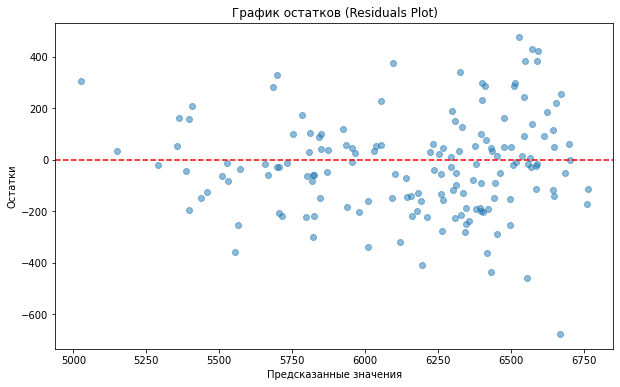

In [42]:
residuals = y_test - predictions_2
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Предсказанные значения")
plt.ylabel("Остатки")
plt.title("График остатков (Residuals Plot)")
plt.show()

Распределение остатков:

Остатки распределены вокруг горизонтальной линии y=0, что свидетельствует об отсутствии сильного смещения. Большая часть точек расположена в пределах от -200 до 200, что указывает на относительно небольшие ошибки предсказаний.
Это хорошее распределение для линейной регрессии, так как остатки кажутся случайно разбросанными вокруг нуля.

Отсутствие явной структуры:
На графике нет очевидного тренда или систематического отклонения остатков. Это предполагает, что модель справляется с описанием данных и не пропускает значительных нелинейных зависимостей.
Если бы остатки формировали какой-то паттерн, это указывало бы на то, что модель не полностью описывает взаимосвязи в данных.


В графике присутствует несколько выбросов, например, одна точка выше 400 и несколько ниже -400. Эти точки могут представлять аномалии или данные, которые модель не может точно предсказать.
Если выбросы оказывают значительное влияние, их стоит проанализировать дополнительно, возможно, проверив качество данных или добавив дополнительные признаки.

Часть 3

In [43]:
ferma = ferma_main.merge(ferma_dad, on='id', how='left')
ferma.head()

,id,удой(кг),эке,сырой протеин(г),спо,порода,тип пастбища,порода папы,жирность(%),белок(%),вкус,возраст,эке_2,имя папы
0,1,5863,14.2,1743,менее_0.92,Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,201.64,Буйный
1,2,5529,12.8,2138,менее_0.92,Айдиал,равнинное,Соверинг,3.54,3.079,вкусно,менее_2_лет,163.84,Соловчик
2,3,5810,14.0,1854,менее_0.92,Соверинг,холмистое,Соверинг,3.59,3.074,не вкусно,более_2_лет,196.00,Барин
3,4,5895,12.4,2012,менее_0.92,Соверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,153.76,Буйный
4,5,5302,12.8,1675,менее_0.92,Айдиал,равнинное,Соверинг,3.73,3.073,вкусно,менее_2_лет,163.84,Барин


In [44]:
X = ferma[['эке_2', 'сырой протеин(г)', 'спо', 'порода', 'тип пастбища', 'возраст', 'порода папы', 'имя папы']]
y = ferma['удой(кг)']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

In [45]:
encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='error')
cat_col_names = ['спо', 'порода', 'тип пастбища', 'возраст', 'порода папы', 'имя папы']
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

In [46]:
scaler = StandardScaler()
num_col_names = ['эке_2', 'сырой протеин(г)']
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

In [47]:
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [48]:
X_test

,x0_менее_0.92,x1_Соверинг,x2_холмистое,x3_менее_2_лет,x4_Соверинг,x5_Буйный,x5_Геркулес,x5_Соловчик,эке_2,сырой протеин(г)
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.527089,-0.813322
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.490346,0.026730
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,-0.527089,-0.682405
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.961737,-1.058792
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.561660,-1.413360
...,...,...,...,...,...,...,...,...,...,...
152,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.754809,0.506760
153,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.643423,0.714046
154,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.561660,0.114008
155,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.239936,-0.415116


In [49]:
model_lr_3 = LinearRegression()
model_lr_3.fit(X_train, y_train)
predictions_3 = model_lr_3.predict(X_test)

In [50]:
X_train

,x0_менее_0.92,x1_Соверинг,x2_холмистое,x3_менее_2_лет,x4_Соверинг,x5_Буйный,x5_Геркулес,x5_Соловчик,эке_2,сырой протеин(г)
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.577968,1.079523
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,-1.511438,-0.196920
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.082269,-1.386085
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.150235,0.752230
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.102358,0.828598
...,...,...,...,...,...,...,...,...,...,...
466,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.674102,1.565008
467,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.239936,-0.998788
468,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.890627,-0.818777
469,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.102358,0.130373


In [51]:
r2_model_3 = r2_score(y_test, predictions_3)
mse_model_3 = mean_squared_error(y_test, predictions_3)
mae_model_3 = mean_absolute_error(y_test, predictions_3)
rmse_model_3 = np.sqrt(mse_model_3)

results = {
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'R²': [r2_model_1, r2_model_2, r2_model_3],
    'MSE': [mse_model_1, mse_model_2, mse_model_3],
    'MAE': [mae_model_1, mae_model_2, mae_model_3],
    'RMSE': [rmse_model_1, rmse_model_2, rmse_model_3]
}
results

{'Model': ['Model 1', 'Model 2', 'Model 3'],
 'R²': [0.7844078173416966, 0.8180879926867501, 0.8247542745210406],
 'MSE': [43887.01500966053, 37030.91131113696, 35673.88988618197],
 'MAE': [164.2419446347493, 149.03965222364607, 146.16302445362322],
 'RMSE': [209.49227911706086, 192.43417396901455, 188.87532895055926]}

In [52]:
st.t.interval(confidence=0.95, df=len(predictions_3)-1, loc=np.mean(predictions_3), scale=st.sem(predictions_3))

(6091.835660789232, 6221.879485123439)

Этот интервал показывает, что при уровне доверия 95% истинное среднее значение предсказаний predictions_3 находится в диапазоне от 6091.84 до 6221.88.

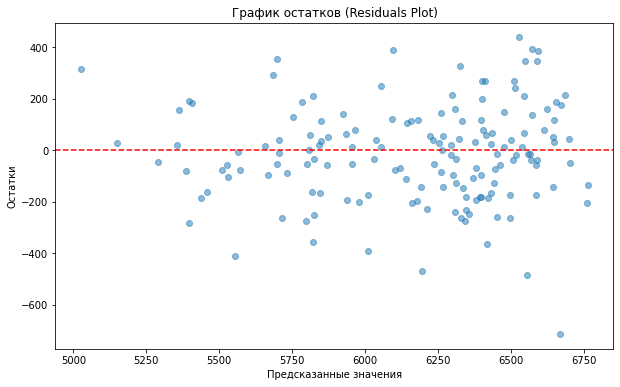

In [53]:
residuals = y_test - predictions_3
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Предсказанные значения")
plt.ylabel("Остатки")
plt.title("График остатков (Residuals Plot)")
plt.show()

In [54]:
errors = y_test - predictions_3
quantiles=(0.025, 0.975)

lower_quantile = np.quantile(errors, quantiles[0])
upper_quantile = np.quantile(errors, quantiles[1])

print(f"Доверительный интервал прогноза: [{lower_quantile}, {upper_quantile}]")

Доверительный интервал прогноза: [-393.099637079012, 355.93715119412155]


<br/>
<div class="alert alert-info">


Результат [-393.1, 355.9] означает, что:

Нижняя граница 95%-го доверительного интервала для ошибок составляет примерно -393.1.

Верхняя граница 95%-го доверительного интервала для ошибок составляет примерно 355.9.

Этот интервал указывает, что большинство ошибок прогноза находятся в диапазоне от -393.1 до 355.9 с 95%-й уверенностью.
Отрицательная нижняя граница говорит о том, что некоторые предсказания завышают фактические значения, тогда как положительная верхняя граница показывает, что другие предсказания занижают их.
</div>

Третья модель показала наилучший результат среди всех, наибольший коэффициент детерминации и наименьшие ошибки. Воспользуемся именно этой моделью для получения прогноза по удою.

Равномерное распределение остатков: точки, представляющие остатки, расположены примерно равномерно выше и ниже красной линии на уровне нуля. Это говорит о том, что предсказания модели не имеют явных систематических отклонений, что является положительным признаком.

Отсутствие видимого тренда: остатки не демонстрируют какого-либо выраженного тренда или структуры (например, линейного или нелинейного), что также указывает на то, что модель хорошо справляется с описанием данных.


In [55]:
eke = ferma_main_['эке'].mean()
spo = ferma_main_['спо'].mean()
sp = ferma_main_['сырой протеин(г)'].mean()
cow_buy['эке'] = eke * 1.05
cow_buy['сырой_протеин(г)'] = sp * 1.05
cow_buy['спо'] = spo * 1.05

cow_buy_copy = cow_buy.copy()

cow_buy_copy['спо'] = cow_buy['спо'].apply(lambda x: 'менее_0.92' if x < 0.92 else 'более_0.92')
cow_buy_copy['эке_2'] = cow_buy['эке'].apply(lambda x: x**2)

cow_buy_copy.head()


,порода,тип пастбища,порода папы,имя папы,текущая жирность(%),текущий белок(%),возраст,эке,сырой_протеин(г),спо,эке_2
0,Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,более_0.92,233.361138
1,Айдиал,равнинное,Соверинг,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,более_0.92,233.361138
2,Соверинг,равнинное,Соверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,более_0.92,233.361138
3,Соверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,более_0.92,233.361138
4,Соверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,более_0.92,233.361138


In [56]:
# cat_col_names = ['спо', 'порода', 'тип пастбища', 'возраст', 'порода папы', 'имя папы']
cow_buy_ohe = encoder.transform(cow_buy_copy[cat_col_names])
encoder_col_names = encoder.get_feature_names()

cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns=encoder_col_names)

In [57]:
num_col_names = ['эке_2', 'сырой_протеин(г)']
cow_buy_scaled = scaler.transform(cow_buy_copy[num_col_names])

cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)



In [58]:
cow_buy_new = pd.concat([cow_buy_ohe, cow_buy_scaled], axis=1)
# cow_buy_new.insert(loc=0,
#                    column='x0_менее_0.92',
#                    value = 0.0)
cow_buy_new.head(5)

,x0_менее_0.92,x1_Соверинг,x2_холмистое,x3_менее_2_лет,x4_Соверинг,x5_Буйный,x5_Геркулес,x5_Соловчик,эке_2,сырой_протеин(г)
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.542248,0.517384
1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.542248,0.517384
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.542248,0.517384
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.542248,0.517384
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.542248,0.517384


In [59]:
cow_buy

,порода,тип пастбища,порода папы,имя папы,текущая жирность(%),текущий белок(%),возраст,эке,сырой_протеин(г),спо
0,Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744
1,Айдиал,равнинное,Соверинг,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744
2,Соверинг,равнинное,Соверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744
3,Соверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744
4,Соверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744
5,Соверинг,равнинное,Соверинг,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744
7,Айдиал,равнинное,Соверинг,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744
9,Соверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744
10,Айдиал,холмистое,Соверинг,Соловчик,3.73,3.055,более_2_лет,15.276162,2019.947532,0.958744
11,Соверинг,равнинное,Соверинг,Геркулес,3.73,3.073,более_2_лет,15.276162,2019.947532,0.958744


In [60]:
cow_buy_new.columns = ['спо_менее_0.92',
                       'порода_Соверинг',
                       'тип пастбища_холмистое',
                       'возраст_менее_2_лет',
                       'порода папы_Соверинг',
                       'имя папы_Буйный',
                       'имя папы_Геркулес',
                       'имя папы_Соловчик',
                       'эке_2',
                       'сырой протеин(г)']
cow_buy_new

,спо_менее_0.92,порода_Соверинг,тип пастбища_холмистое,возраст_менее_2_лет,порода папы_Соверинг,имя папы_Буйный,имя папы_Геркулес,имя папы_Соловчик,эке_2,сырой протеин(г)
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.542248,0.517384
1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.542248,0.517384
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.542248,0.517384
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.542248,0.517384
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.542248,0.517384
5,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.542248,0.517384
6,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.542248,0.517384
7,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.542248,0.517384
8,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.542248,0.517384
9,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.542248,0.517384


In [61]:
cow_buy['удой(кг)'] = model_lr_3.predict(cow_buy_new)
pred_4 = model_lr_3.predict(cow_buy_new)
cow_buy

,порода,тип пастбища,порода папы,имя папы,текущая жирность(%),текущий белок(%),возраст,эке,сырой_протеин(г),спо,удой(кг)
0,Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,6609.919297
1,Айдиал,равнинное,Соверинг,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,6378.711028
2,Соверинг,равнинное,Соверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,6283.999775
3,Соверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,6593.089377
4,Соверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,6542.146066
5,Соверинг,равнинное,Соверинг,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,6425.380218
7,Айдиал,равнинное,Соверинг,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,6571.259737
9,Соверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,6400.540668
10,Айдиал,холмистое,Соверинг,Соловчик,3.73,3.055,более_2_лет,15.276162,2019.947532,0.958744,6344.707860
11,Соверинг,равнинное,Соверинг,Геркулес,3.73,3.073,более_2_лет,15.276162,2019.947532,0.958744,6617.928926


In [62]:
len(cow_buy[cow_buy['удой(кг)'] > 6000])

16

In [63]:
st.t.interval(confidence=0.95, df=len(pred_4)-1, loc=np.mean(pred_4), scale=st.sem(pred_4))

(6387.493201091697, 6542.4460716665735)

Этот интервал показывает, что при уровне доверия 95% истинное среднее значение финальных предсказаний удоя находится в диапазоне от 6387.49 до 6542.45.


16 коров подходят по удою, именно такое количество дает больше 6000 кг молока в год.


## Обучение модели логистической регрессии

In [64]:
y = ferma['вкус']
X = ferma[['эке_2', 'сырой протеин(г)', 'спо', 'порода папы', 'имя папы', 'жирность(%)', 'белок(%)', 'тип пастбища', 'возраст', 'порода']]
# признаки, которые могут влиять на вкус
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=42
)
y_train = y_train.map({'вкусно': 0, 'не вкусно': 1}).astype(int)
y_test = y_test.map({'вкусно': 0, 'не вкусно': 1}).astype(int)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(471, 10)
(157, 10)
(471,)
(157,)


In [65]:
encoder = OneHotEncoder(drop='first', sparse=False)
cat_col_names = ['спо', 'тип пастбища', 'возраст']
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

In [66]:
scaler = StandardScaler()
num_col_names = ['эке_2', 'сырой протеин(г)', 'жирность(%)', 'белок(%)']
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

In [67]:
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [68]:
clf = LogisticRegression()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [69]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('LogisticRegression model Accuracy = ', round(accuracy, 3))
print('LogisticRegression model Precision = ', round(precision, 3))
print('LogisticRegression model Recall = ', round(recall, 3))

LogisticRegression model Accuracy =  0.637
LogisticRegression model Precision =  0.667
LogisticRegression model Recall =  0.348


Text(0.5, 15.0, 'Predicted')

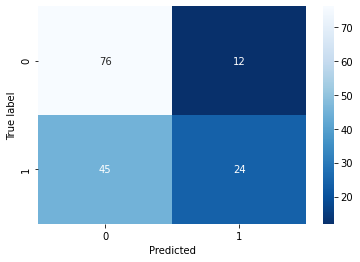

In [70]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')

In [71]:
thresholds = [round(i,2) for i in np.linspace(0.1,0.5,num = 4,endpoint=False)]
print(thresholds)

[0.1, 0.2, 0.3, 0.4]


In [72]:
y_proba = clf.predict_proba(X_test)[:,1]
data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba'])
columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)
data.head()

,y_valid,y_proba,y_pred_0.1,y_pred_0.2,y_pred_0.3,y_pred_0.4
0,0,0.328845,1,1,1,0
1,0,0.258643,1,1,0,0
2,0,0.378390,1,1,1,0
3,1,0.578155,1,1,1,1
4,0,0.215943,1,1,0,0


In [73]:
print('y_pred_0.1 Recall = ', recall_score(y_test, data['y_pred_0.1']))
print('y_pred_0.2 Recall = ', recall_score(data['y_valid'], data['y_pred_0.2']))
print('y_pred_0.3 Recall = ', recall_score(data['y_valid'], data['y_pred_0.3']))
print('y_pred_0.4 Recall = ', recall_score(data['y_valid'], data['y_pred_0.4']))

y_pred_0.1 Recall =  1.0
y_pred_0.2 Recall =  1.0
y_pred_0.3 Recall =  0.8840579710144928
y_pred_0.4 Recall =  0.6376811594202898


In [74]:
thresholds = [0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]
y_proba = clf.predict_proba(X_test)[:,1]
data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba'])
columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

for i in thresholds:
    print(f'y_pred_{i} Recall = ', recall_score(data['y_valid'], data[f'y_pred_{i}']))

y_pred_0.21 Recall =  1.0
y_pred_0.22 Recall =  0.9565217391304348
y_pred_0.23 Recall =  0.9565217391304348
y_pred_0.24 Recall =  0.9565217391304348
y_pred_0.25 Recall =  0.9565217391304348
y_pred_0.26 Recall =  0.9420289855072463
y_pred_0.27 Recall =  0.9420289855072463
y_pred_0.28 Recall =  0.927536231884058
y_pred_0.29 Recall =  0.9130434782608695


In [75]:
thresholds = [0.211, 0.212, 0.213, 0.214, 0.215, 0.216, 0.217, 0.218, 0.219]
y_proba = clf.predict_proba(X_test)[:,1]
data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba'])
columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)

for i in thresholds:
    print(f'y_pred_{i} Recall = ', recall_score(data['y_valid'], data[f'y_pred_{i}']))

y_pred_0.211 Recall =  1.0
y_pred_0.212 Recall =  0.9855072463768116
y_pred_0.213 Recall =  0.9855072463768116
y_pred_0.214 Recall =  0.9855072463768116
y_pred_0.215 Recall =  0.9855072463768116
y_pred_0.216 Recall =  0.9855072463768116
y_pred_0.217 Recall =  0.9855072463768116
y_pred_0.218 Recall =  0.9855072463768116
y_pred_0.219 Recall =  0.9710144927536232


In [76]:
y_pred_new_threshold = (clf.predict_proba(X_test)[:, 1] >= 0.211).astype(int) 
accuracy = accuracy_score(y_test, y_pred_new_threshold)
precision = precision_score(y_test, y_pred_new_threshold)
recall = recall_score(y_test, y_pred_new_threshold)
print('LogisticRegression model Accuracy = ', round(accuracy, 3))
print('LogisticRegression model Precision = ', round(precision, 3))
print('LogisticRegression model Recall = ', round(recall, 3))

LogisticRegression model Accuracy =  0.49
LogisticRegression model Precision =  0.463
LogisticRegression model Recall =  1.0


Text(0.5, 15.0, 'Predicted')

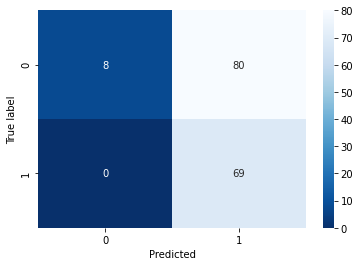

In [77]:
cm = confusion_matrix(y_test, y_pred_new_threshold)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')

Точность модели упала, но фермер обезопасен от ошибки 2 рода

In [78]:
cow_buy

,порода,тип пастбища,порода папы,имя папы,текущая жирность(%),текущий белок(%),возраст,эке,сырой_протеин(г),спо,удой(кг)
0,Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,6609.919297
1,Айдиал,равнинное,Соверинг,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,6378.711028
2,Соверинг,равнинное,Соверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,6283.999775
3,Соверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,6593.089377
4,Соверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,6542.146066
5,Соверинг,равнинное,Соверинг,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,6425.380218
7,Айдиал,равнинное,Соверинг,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,6571.259737
9,Соверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,6400.540668
10,Айдиал,холмистое,Соверинг,Соловчик,3.73,3.055,более_2_лет,15.276162,2019.947532,0.958744,6344.707860
11,Соверинг,равнинное,Соверинг,Геркулес,3.73,3.073,более_2_лет,15.276162,2019.947532,0.958744,6617.928926


In [79]:
cow_buy['эке_2'] = cow_buy['эке'].apply(lambda x: x**2)
cow_buy['спо_тип'] = cow_buy['спо'].apply(lambda x: 'более_0.92' if x>0.92 else 'менее_0.92')
cow_buy

,порода,тип пастбища,порода папы,имя папы,текущая жирность(%),текущий белок(%),возраст,эке,сырой_протеин(г),спо,удой(кг),эке_2,спо_тип
0,Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,6609.919297,233.361138,более_0.92
1,Айдиал,равнинное,Соверинг,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,6378.711028,233.361138,более_0.92
2,Соверинг,равнинное,Соверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,6283.999775,233.361138,более_0.92
3,Соверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,6593.089377,233.361138,более_0.92
4,Соверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,6542.146066,233.361138,более_0.92
5,Соверинг,равнинное,Соверинг,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,6425.380218,233.361138,более_0.92
7,Айдиал,равнинное,Соверинг,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,6571.259737,233.361138,более_0.92
9,Соверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,6400.540668,233.361138,более_0.92
10,Айдиал,холмистое,Соверинг,Соловчик,3.73,3.055,более_2_лет,15.276162,2019.947532,0.958744,6344.707860,233.361138,более_0.92
11,Соверинг,равнинное,Соверинг,Геркулес,3.73,3.073,более_2_лет,15.276162,2019.947532,0.958744,6617.928926,233.361138,более_0.92


In [80]:
cat_col_names = ['спо_тип', 'тип пастбища', 'возраст']
cow_buy_ohe = encoder.transform(cow_buy[cat_col_names])
encoder_col_names = encoder.get_feature_names()

cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns=encoder_col_names)

num_col_names = ['эке_2', 'сырой_протеин(г)', 'текущая жирность(%)', 'текущий белок(%)']
cow_buy_scaled = scaler.transform(cow_buy[num_col_names])

cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)

In [81]:
cow_buy_new = pd.concat([cow_buy_ohe, cow_buy_scaled], axis=1)
# cow_buy_new.insert(loc=0,
#                   column='x0_менее_0.92',
#                   value = 0.0)
cow_buy_new.columns = ['спо_менее_0.92',
                       'тип пастбища_холмистое',
                       'возраст_менее_2_лет',
                       'эке_2',
                       'сырой протеин(г)',
                       'жирность(%)',
                       'белок(%)',]
taste_pred = (clf.predict_proba(cow_buy_new)[:, 1] >= 0.211).astype(int)
taste_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [82]:
cow_buy_new.head(2)

,спо_менее_0.92,тип пастбища_холмистое,возраст_менее_2_лет,эке_2,сырой протеин(г),жирность(%),белок(%)
0,0.0,1.0,0.0,0.542248,0.517384,-0.158918,0.094429
1,0.0,0.0,1.0,0.542248,0.517384,-0.399401,2.028176


In [83]:
X_train.head(2)

,x0_менее_0.92,x1_холмистое,x2_менее_2_лет,эке_2,сырой протеин(г),жирность(%),белок(%)
0,0.0,1.0,0.0,1.577968,1.079523,0.562532,-0.679069
1,1.0,1.0,1.0,-1.511438,-0.196920,-1.601817,-1.452568


Здесь мы видим, что нам не подходит ни одна коровка.

In [85]:
cow_buy['вкус'] = taste_pred
cow_buy['вкус'] = cow_buy['вкус'].map({0: 'вкусно', 1: 'не вкусно'}).astype(str)

In [86]:
cow_buy

,порода,тип пастбища,порода папы,имя папы,текущая жирность(%),текущий белок(%),возраст,эке,сырой_протеин(г),спо,удой(кг),эке_2,спо_тип,вкус
0,Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,6609.919297,233.361138,более_0.92,не вкусно
1,Айдиал,равнинное,Соверинг,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,6378.711028,233.361138,более_0.92,не вкусно
2,Соверинг,равнинное,Соверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,6283.999775,233.361138,более_0.92,не вкусно
3,Соверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,6593.089377,233.361138,более_0.92,не вкусно
4,Соверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,6542.146066,233.361138,более_0.92,не вкусно
5,Соверинг,равнинное,Соверинг,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,6425.380218,233.361138,более_0.92,не вкусно
7,Айдиал,равнинное,Соверинг,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,6571.259737,233.361138,более_0.92,не вкусно
9,Соверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,6400.540668,233.361138,более_0.92,не вкусно
10,Айдиал,холмистое,Соверинг,Соловчик,3.73,3.055,более_2_лет,15.276162,2019.947532,0.958744,6344.707860,233.361138,более_0.92,не вкусно
11,Соверинг,равнинное,Соверинг,Геркулес,3.73,3.073,более_2_лет,15.276162,2019.947532,0.958744,6617.928926,233.361138,более_0.92,не вкусно


Нам не подходит ни одна коровка.
У всех коровок невкусное молоко, хоть и удой больше 6к кг в год.

Итоговые выводы: 

Модель линейной регрессии использовалась для прогнозирования целевого признака удой: фермеру необходимы были коровы с удоем более 6000кг в год. Собрав наилучшую модель с показателем коэффициента детерминации 0.824, мы пришли к выводу, что фермеру подходит 16 коров, именно такое количество дает удой больше требуемого.
В случае с логистической регрессии мы должны были максимизировать метрику recall, чтобы фермер не стал жертвой ошибки второго рода: когда прогнозируется вкусное молоко, хотя по факту оно не вкусное. 
Мы подобрали такое значение, чтобы FN = 0, 